# Ryder: Global Expansion Research #
<a id="top" />

This Jupyter notebook contains the summaries and visualizations that should accompany the report on Ryder's company expansion into other countries, based on key indicators derived from a country's level of crime and stability, basic measures of health and wealth, and ratios of public education spending.

***

## Table of Contents ##

1. [Title](#top)
2. [Introduction](#introduction)
3. [Dependencies](#dependencies)
4. [Helpers](#helpers)
5. [Queries](#queries)

***

<a id="introduction" />

## Introduction ##

This notebook contains queries made against cleansed versions of the following Kaggle datasets:

- [Global Terrorism Database](https://www.kaggle.com/START-UMD/gtd) (2018)
- [Infant Mortality, Fertility, Income per Capita](https://www.kaggle.com/burhanykiyakoglu/infant-mortality-fertility-income) (2018)
- [Public Education Expenditure as share of GDP](https://www.kaggle.com/ibrahimmukherjee/gdp-world-bank-data#public-education-expenditure-as-share-of-gdp.csv) (2018)

Datasets were prepared using a combination of different commandline tools, including `bash`, `awk`, `sed`, and `python`. The original wide datasets were broken up to better facilitate querying. Details on that process are included in the accompanying documentation.

***

<a id="dependencies" />

## Dependencies ##

This notebook requires the following packages:

    - numpy
    - pandas 
    - matplotlib

Before we can plot information and fiddle with the data, we need to import these modules.


In [1]:
import numpy as np         # numpy library for vectorized computations.
import pandas as pd        # pandas library for manipulating dataframes.

### pandas & numpy ###

Pandas allows us to manipulate dataframes.

We can create these dataframes by reading in our data. `*.tsv` files can be imported using the `read_csv()` function. Note the custom `\t` separator used with tab-separated-value files.

```python
# Outputs a dataframe from a parsed data file.
dataframe = pd.read_csv("<filename>.tsv", sep="\t")
```

### matplotlib ###

We can also import matplotlib and the pylot modules for configuration and later use.

In [2]:
import matplotlib as mpl   # matplotlib library for global settings.
import matplotlib.pyplot as plt  # Our plotting functions from matplotlib.

In [3]:
print(plt.style.available)  # Display what styles are available.

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


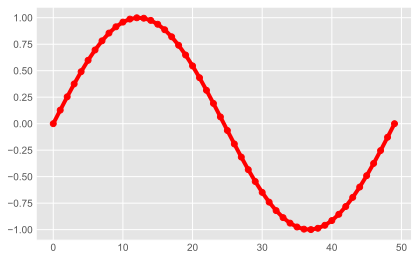

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
                                     # Above lines makes plots appear as inline svgs.
mpl.rcParams['figure.dpi'] = 300     # Apply DPI to matplotlib inline plots.
plt.style.use(['fivethirtyeight', 'seaborn-dark', 'ggplot'])     # Apply particular styles.
plt.plot(np.sin(np.linspace(0, 2 * np.pi)), 'r-o')  # Make the plot.
plt.show()  # Show the plot.

***

<a id="helpers"></a>

## Helpers ##

The following packages contain support functions unique to this particular report.

The `analysis.analyser` package contains the `analyser` and `country` modules that do a bulk of the computational work. The `analysis.utils` package contains utility modules used to do repetitive tasks across the entire project.

In [5]:
from analysis.analyser import analyser
from analysis.analyser.country import Country
from analysis.utils import parser
from analysis.utils import validate

In [6]:
# Outputs a dataframe from a parsed data file.
countries_df = parser.read_tsv("../data/country_codes.tsv")

In [7]:
# Get np.array of unique countries that appear in 
# the public education expenditure dataset.
ped_countries_df = parser.read_tsv("../data/ped/ped_countries.tsv")
keys_ped = Country.from_frame(countries_df, search=list(ped_countries_df.iloc[:,0].unique()))
print(Country.format(keys_ped, sep="\n"))
#keys_ped = [Country.from_frame(countries_df, search=unique_code) for unique_code in list(ped_countries_df.iloc[:,0].unique())]

Found 17 result(s) for search terms: AUS, AUT, BEL, CAN, CHE, DEU, ESP, FRA, GBR, IRL, ITA, JPN, NLD, NOR, NZL, SWE, USA
<[AUS 14]: "Australia">
<[AUT 15]: "Austria">
<[BEL 21]: "Belgium">
<[CAN 38]: "Canada">
<[CHE 199]: "Switzerland">
<[DEU 75]: "Germany">
<[ESP 185]: "Spain">
<[FRA 69]: "France">
<[GBR 603]: "United Kingdom">
<[IRL 96]: "Ireland">
<[ITA 98]: "Italy">
<[JPN 101]: "Japan">
<[NLD 142]: "Netherlands">
<[NOR 151]: "Norway">
<[NZL 144]: "New Zealand">
<[SWE 198]: "Sweden">
<[USA 217]: "United States">


In [8]:
# Get np.array of unique countries that appear in 
# the infant mortality, fertility, income per capita dataset.
mfi_countries_df = parser.read_tsv("../data/mfi/mfi_countries.tsv")
keys_mfi = Country.from_frame(countries_df, search=mfi_countries_df.iloc[:,0].unique())
print(Country.format(keys_mfi[:5], sep="\n"), "\n...\n", Country.format(keys_mfi[-5:], sep="\n"))

Found 161 result(s) for search terms: ABW, AFG, AGO, ALB, AND, ARE, ARG, ARM, ASM, ATG, AUS, AUT, AZE, BDI, BEL, BEN, BFA, BGD, BGR, BHR, BHS, BIH, BLR, BLZ, BMU, BOL, BRA, BRB, BRN, BTN, BWA, CAF, CAN, CHE, CHI, CHL, CHN, CIV, CMR, COD, COG, COL, COM, CPV, CRI, CUB, CUW, CYM, CYP, CZE, DEU, DJI, DMA, DNK, DOM, DZA, ECU, EGY, ERI, ESP, EST, ETH, FIN, FJI, FRA, FRO, FSM, GAB, GBR, GEO, GHA, GIB, GIN, GMB, GNB, GNQ, GRC, GRD, GRL, GTM, GUM, GUY, HKG, HND, HRV, HTI, HUN, IDN, IMN, IND, IRL, IRN, IRQ, ISL, ISR, ITA, JAM, JOR, JPN, KAZ, KEN, KGZ, KHM, KIR, KNA, KOR, KWT, LAO, LBN, LBR, LBY, LCA, LIE, LKA, LSO, LTU, LUX, LVA, MAC, MAF, MAR, MCO, MDA, MDG, MDV, MEX, MHL, MKD, MLI, MLT, MMR, MNE, MNG, MNP, MOZ, MRT, MUS, MWI, MYS, NAM, NCL, NER, NGA, NIC, NLD, NOR, NPL, NRU, NZL, OMN, PAK, PAN, PER, PHL, PLW, PNG, POL, PRI, PRK, PRT, PRY, PSE, PYF, QAT, ROU, RUS, RWA, SAU, SDN, SEN, SGP, SLB, SLE, SLV, SMR, SOM, SRB, SSD, STP, SUR, SVK, SVN, SWE, SWZ, SXM, SYC, SYR, TCA, TCD, TGO, THA, TJK, TK

In [9]:
# Get np.array of unique countries that appear in 
# the global terrorism database.
gtd_countries_df = parser.read_tsv("../data/gtd/gtd_countries.tsv")
keys_gtd = Country.from_frame(countries_df, search=gtd_countries_df.iloc[:,0].unique())
print(Country.format(keys_gtd[:5], sep="\n"), "\n...\n", Country.format(keys_gtd[-5:], sep="\n"))

Found 161 result(s) for search terms: 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 127, 128, 129, 130, 132, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 149, 151, 153, 155, 156, 157, 158, 159, 160, 161, 162, 164, 166, 167, 168, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 189, 190, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 207, 208, 209, 210, 213, 214, 215, 217, 218, 219, 220, 221, 222, 223, 226, 228, 229, 230, 231, 235, 236, 347, 349, 359, 362, 377, 403, 406, 422, 428, 499, 532, 603, 604, 605, 1001, 1002, 1003, 1004
<[AFG 4]: "Afghanistan">

In [10]:
# Compute the unique available countries among the datasets.
country_codes = {
    "ped": list(map(lambda country: country.code, keys_ped)),
    "mfi": list(map(lambda country: country.code, keys_mfi)),
    "gtd": list(map(lambda country: country.code, keys_gtd))
}

# Find the available countries.
unique_codes = analyser.find_intersection(*country_codes.values())
available_countries = countries_df[countries_df["Code"].isin(unique_codes)]
available_countries

# print(available_countries, sep="\n")

,ID,Code,Country
8,14,AUS,Australia
9,15,AUT,Austria
14,21,BEL,Belgium
27,38,CAN,Canada
51,69,FRA,France
55,75,DEU,Germany
70,96,IRL,Ireland
72,98,ITA,Italy
74,101,JPN,Japan
101,142,NLD,Netherlands


In [11]:
# Clear unused variables in IPython.
%reset_selective -f "^id$"
%reset_selective -f "^code$"
%reset_selective -f "^name$"

# Equivalent: del keys_ped
# Equivalent: del keys_mfi
# Equivalent: del keys_gtd
%reset_selective -f "_ped$"
%reset_selective -f "_mfi$"
%reset_selective -f "_gtd$"

# Equivalent: del ped_countries_df
# Equivalent: del mfi_countries_df
# Equivalent: del gtd_countries_df
%reset_selective -f "_countries_df$"

# Equivalent: del country_codes
# Equivalent: del unique_codes
%reset_selective -f "_codes$"

***

<a id="queries" />

## Queries ##

The objective of the research project is to evaluate key indicators of stability and growth across several countries in order to estimate Ryder's potential for success in these new markets.

This sample report evaluates the trends in three (3) separate countries as a sampling of what the broader international research has to offer. **The United Kingdom** (GBR), **Japan** (JPN), and **Sweden** (SWE).

The **United States of America** (USA) is included in order to use our current operation region for context.

In [12]:
# The countries we want to evaluate.
codes = [
    "GBR",  # United Kingdom,
    "JPN",  # Japan,
    "SWE",  # Sweden,
    "USA"   # United States
    ]
print(codes, sep="\n")

['GBR', 'JPN', 'SWE', 'USA']


In [13]:
# Select these countries from the set of available countries.
selected_df = available_countries[available_countries["Code"].isin(codes)]
selected_df.set_index("Code", drop=False, inplace=True)
selected_df

,ID,Code,Country
Code,,,
JPN,101,JPN,Japan
SWE,198,SWE,Sweden
USA,217,USA,United States
GBR,603,GBR,United Kingdom


In [14]:
# Convert selected countries into Country representations for use across all datasets.
selected_countries = Country.get_countries(selected_df)
print(Country.format(selected_countries, sep="\n"))

<[JPN 101]: "Japan">
<[SWE 198]: "Sweden">
<[USA 217]: "United States">
<[GBR 603]: "United Kingdom">


In order to query the data, we need to form our `pandas.DataFrame` representations.

For the infant mortality, fertility, and income per capita datasets, we need to assign a MultiIndex using the country code and the year.

In [15]:
# Get the mortality table using the parser.read_mfi helper function.
mortality_df = parser.read_mfi(
    '../data/mfi/mortality/mortality_long.tsv', 
    title="Mortality Rate",
    countries=selected_df.index)    
mortality_df

,original_index,Code,Country,Year,Mortality Rate
0,45,GBR,United Kingdom,1970,18.0
1,184,GBR,United Kingdom,1971,17.7
2,327,GBR,United Kingdom,1972,17.1
3,473,GBR,United Kingdom,1973,16.6
4,620,GBR,United Kingdom,1974,16.0
...,...,...,...,...,...
183,7790,USA,United States,2012,6.0
184,7983,USA,United States,2013,5.9
185,8176,USA,United States,2014,5.8
186,8369,USA,United States,2015,5.7


In [16]:
# Get the fertility table using the parser.read_mfi helper function.
fertility_df = parser.read_mfi(
    '../data/mfi/fertility/fertility_long.tsv', 
    title="Income",
    countries=selected_df.index)    
fertility_df

,original_index,Code,Country,Year,Income
0,62,GBR,United Kingdom,1970,2.4
1,253,GBR,United Kingdom,1971,2.4
2,446,GBR,United Kingdom,1972,2.2
3,638,GBR,United Kingdom,1973,2.0
4,829,GBR,United Kingdom,1974,1.9
...,...,...,...,...,...
183,8434,USA,United States,2012,1.9
184,8634,USA,United States,2013,1.9
185,8834,USA,United States,2014,1.9
186,9035,USA,United States,2015,1.8


In [17]:
# Get the income table using the parser.read_mfi helper function.
income_df = parser.read_mfi(
    '../data/mfi/income/income_long.tsv', 
    title="Income",
    countries=selected_df.index)    
income_df

,original_index,Code,Country,Year,Income
0,21,GBR,United Kingdom,1970,2220.021490
1,79,GBR,United Kingdom,1971,2484.150369
2,158,GBR,United Kingdom,1972,2823.686879
3,238,GBR,United Kingdom,1973,3192.310330
4,318,GBR,United Kingdom,1974,3393.134062
...,...,...,...,...,...
183,5729,USA,United States,2012,44582.333450
184,5900,USA,United States,2013,45548.288240
185,6069,USA,United States,2014,47344.285540
186,6239,USA,United States,2015,49058.089400


For each of these countries, we want to answer the following questions:

    1. Is infant mortality improving, stable, or getting worse?
    2. Is income rising, stagnant, or falling?
    3. Does one country or another seem more or less stable than the others, and why do you say this?
    4. What changes do you predict for these countries, and why?

### Infant Mortality ###

For **each country** in `selected_countries`, observations regarding infant mortality per 1,000 live births can be determined with the following steps:

- Summraize rates of infant mortality per 1,000 live births per year, for each country.

- Plot a time-series showing infant mortality trends in each country.

In [18]:
# Query 1a. Average infant mortality per 1,000 live births per year, by country.
# print(describe_numeric(mortality_df.groupby(['Code']), 'Mortality Rate'))
mortality_stats_year = mortality_df.groupby(['Code']).agg({
    'Year': [
        'count',
        'min',
        'max',
        analyser.spread(),
        analyser.percentile(0),
        analyser.percentile(0.25),
        analyser.percentile(0.5),
        analyser.percentile(0.75),
        analyser.percentile(1),
        analyser.IQR()
    ]
}).dropna(axis=1,how='all')
print(mortality_stats_year)

mortality_stats_rate = mortality_df.groupby(['Code']).agg({
    'Mortality Rate': [
        'min',
        'idxmin',
        'max',
        'idxmax'
    ]
}).dropna(axis=1,how='all')
print(mortality_stats_rate)

mortality_quartiles = mortality_df.groupby(['Code']).agg({ 
    'Mortality Rate': [ 
        analyser.percentile(0), 
        analyser.percentile(0.25),
        analyser.percentile(0.5),
        analyser.percentile(0.75),
        analyser.percentile(1),
        analyser.IQR(),
        analyser.spread()
    ]
})
print(mortality_quartiles)

      Year                                                        
     count   min   max range    0%     25%   50%     75%  100% IQR
Code                                                              
GBR     47  1970  2016    46  1970  1981.5  1993  2004.5  2016  23
JPN     47  1970  2016    46  1970  1981.5  1993  2004.5  2016  23
SWE     47  1970  2016    46  1970  1981.5  1993  2004.5  2016  23
USA     47  1970  2016    46  1970  1981.5  1993  2004.5  2016  23
     Mortality Rate                    
                min idxmin   max idxmax
Code                                   
GBR             3.7     45  18.0      0
JPN             2.0     91  13.4     47
SWE             2.4    137  11.3     94
USA             5.6    187  19.9    141
     Mortality Rate                                    
                 0%   25%  50%    75%  100%   IQR range
Code                                                   
GBR             3.7  5.20  6.5  11.10  18.0  5.90  14.3
JPN             2.0  2.80  

Plotting Infant mortality rate, by country (1970 to 2016) for each 4 countr(y/ies) across 47 year(s)...


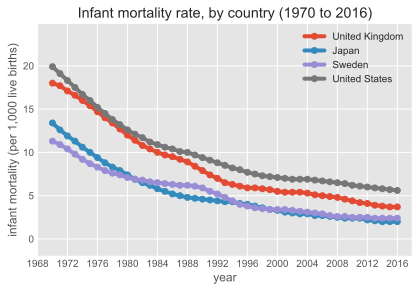

In [19]:
# Query 1b. Time-series plot showing infant mortality trends, by country.

df = mortality_df.drop(labels=['original_index'], axis=1)

num_years = df['Year'].nunique()
num_countries = df['Code'].nunique()
year_min = df['Year'].min()
year_max = df['Year'].max()

options = {
    'xlabel': 'year',
    'ylabel': 'infant mortality (per 1,000 live births)',
    'title': f'Infant mortality rate, by country ({year_min} to {year_max})',
    'xlim': (year_min - 2, year_max + 2),
    'ylim': (-2, df['Mortality Rate'].max() * 1.25),
}

# Plot the mortality information.
print(f'Plotting {options["title"]} for each {num_countries} countr(y/ies) across {num_years} year(s)...')
fig, ax = plt.subplots()

for key, grp in df.groupby(['Code']):
    ax.plot('Year', 'Mortality Rate', 'o-', data=grp, label=df[df['Code'] == key]['Country'].unique()[0])

ax.set(**options)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(15))

ax.legend(loc='upper right', frameon=False)
ax.grid(True)

### National Net Income per Capita ###

For **each country** in `selected_countries`, observations regarding NNI per Capita (in 2018 $USD) can be determined with the following steps:

- Summarize the NNI per Capita per year, for each country.

- Plot a time-series showing NNI per Capita trends in each country.

In [20]:
# Query 2a. Summarize the NNI per Capita per year, for each country.
income_stats = income_df.groupby(['Code']).agg({
    'Income': [
        'min',
        'idxmin',
        'max',
        'idxmax'
    ]
}).dropna(axis=1,how='all')
print(income_stats)

income_quartiles = income_df.groupby(['Code']).agg({ 
    'Income': [ 
        analyser.percentile(0), 
        analyser.percentile(0.25),
        analyser.percentile(0.5),
        analyser.percentile(0.75),
        analyser.percentile(1),
        analyser.IQR(),
        analyser.spread()
    ]
})
print(income_quartiles)


           Income                           
              min idxmin          max idxmax
Code                                        
GBR   2220.021490      0  43373.05583     37
JPN   1669.294920     47  38613.65124     89
SWE   4162.080806     94  51423.65653    137
USA   4591.218634    141  49725.78053    187
           Income                                                        \
               0%           25%          50%           75%         100%   
Code                                                                      
GBR   2220.021490   7383.203197  17406.97758  33321.134415  43373.05583   
JPN   1669.294920   8167.404551  25157.27898  30266.593825  38613.65124   
SWE   4162.080806  11549.905215  24782.95466  36537.575590  51423.65653   
USA   4591.218634  11739.246895  21977.62957  36657.289395  49725.78053   

                                  
               IQR         range  
Code                              
GBR   25937.931218  41153.034340  
JPN   22099.189274 

Plotting NNI per Capita, by country (1970 to 2016) in 2018 $USD for each 4 countr(y/ies) across 47 year(s)...


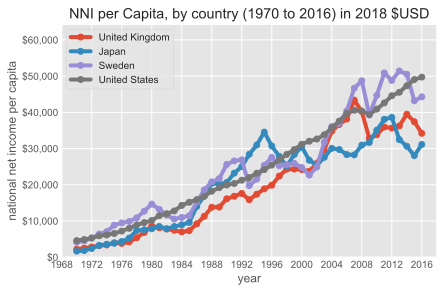

In [21]:
# Query 2b. Plot a time-series showing NNI per Capita trends in each country.
df = income_df.drop(labels=['original_index'], axis=1)

num_years = df['Year'].nunique()
num_countries = df['Code'].nunique()
year_min = df['Year'].min()
year_max = df['Year'].max()

options = {
    'xlabel': 'year',
    'ylabel': 'national net income per capita',
    'title': f'NNI per Capita, by country ({year_min} to {year_max}) in 2018 $USD',
    'xlim': (year_min - 2, year_max + 2),
    'ylim': (-2, df['Income'].max() * 1.25),
}

# Plot the mortality information.
print(f'Plotting {options["title"]} for each {num_countries} countr(y/ies) across {num_years} year(s)...')
fig, ax = plt.subplots()

for key, grp in df.groupby(['Code']):
    ax.plot('Year', 'Income', 'o-', data=grp, label=df[df['Code'] == key]['Country'].unique()[0])

ax.set(**options)

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(15))
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('${x:,.0f}'))

ax.legend(loc='upper left', frameon=True)
ax.grid(True)

plt.show()

### Crime & Stability ###

For **each country** in `selected_countries`, observations regarding terrorist incidents can be determined with the following steps:

- Summarize the terrorism incidents per year, for each country.

- Plot a time-series showing crime and stability in each country.

In [22]:
# Query 3a. Summarize the terrorism incidents per year, for each country.
# crime_df = parser.read_tsv('../data/')

In [23]:
# Query 3b. Plot a time-series showing crime and stability in each country.

### Predictions ###

Predictions 

#### The United States ####

Is it stable?
Is it a good fit?

This serves as a baseline to compare to other countries.

#### The United Kingdom ####

Is it stable?
Is it a good fit?
How does it compare to the USA?

#### Sweden ####

Is it stable?
Is it a good fit?
How does it compare to the USA?

Other considerations: Language. Would need to hire new staff.

#### Japan ####

Is it stable?
Is it a good fit?
How does it compare to the USA?

Other considerations: Language. Would need to hire new staff.